In [1]:
# bash 셸로 명령어 입력하여 라이브러리 설치하기

%%bash
apt-get update 
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

# JAVA_HOME 환경변수 설정하기

%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

pip3 install tqdm # 진행바를 출력

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [89.9 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [903 kB]
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bioni

bash: line 8: fg: no job control


In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
import urllib.request

from konlpy.tag import Okt
import urllib.request
from gensim.models import Word2Vec
from tqdm import tqdm

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") 
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")


##  1. 데이터 불러오기  ###############################################
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

# #   데이터 확인
# train_data.info()

# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 150000 entries, 0 to 149999
# Data columns (total 3 columns):
#  #   Column    Non-Null Count   Dtype 
# ---  ------    --------------   ----- 
#  0   id        150000 non-null  int64 
#  1   document  149995 non-null  object
#  2   label     150000 non-null  int64 
# dtypes: int64(2), object(1)
# memory usage: 3.4+ MB

# print('댓글 개수 : ', len(train_data)) #댓글 개수 :  150000
# print('댓글 개수 : ', len(test_data)) #댓글 개수 :  50000

#   내용 확인
# train_data.head()
# id	document	label
# 0	9976970	아 더빙.. 진짜 짜증나네요 목소리	0
# 1	3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
# 2	10265843	너무재밓었다그래서보는것을추천한다	0
# 3	9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
# 4	6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...	1

# test_data.head()
# id	document	label
# 0	6270596	굳 ㅋ	1
# 1	9274899	GDNTOPCLASSINTHECLUB	0
# 2	8544678	뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아	0
# 3	6825595	지루하지는 않은데 완전 막장임... 돈주고 보기에는....	0
# 4	6723715	3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??	0

# 특수문자, 영어 등을 나중에 제외해야함

#   중복 확인
# train_data['document'].nunique() #nunique 중복 제거한 개수를 출력 146182 ; 150000개 중에 3000개 정도 중복이 됨
# test_data['document'].nunique() #nunique 중복 제거한 개수를 출력 49157 ; 50000 중에 900 정도 중복이 됨

#   중복 삭제
train_data.drop_duplicates(subset=['document'],inplace=True) # document컬럼중에 중복을 제거함
test_data.drop_duplicates(subset=['document'],inplace=True) # document컬럼중에 중복을 제거함

# print('중복 제거후 댓글 개수 : ', len(train_data)) #댓글 개수 :  146183
# print('중복 제거후 댓글 개수 : ', len(test_data)) #댓글 개수 :  49158

#   라벨 값 확인
#  label의 개수를 바그래프로 그려줌 (1,0의 데이터 비율을 1대1로 무조건 맞춰줘야함)
# train_data['label'].value_counts().plot(kind='bar')
# test_data['label'].value_counts().plot(kind='bar')


#   라벨의 값으로 개수를 출력
# train_data.groupby('label').size().reset_index(name='count')



#   데이터 개수 확인 (null 제거)
#null개수 확인
# train_data 의 어디든지 null이 있으면 true 없으면 false
# train_data.isnull().values.any()  #True
# train_data.isnull().sum()  #document에 하나
# train_data.loc[train_data.document.isnull()] #null이 document에 null의 인덱스를 알려줌
# id	document	label
# 25857	2172111	NaN	1

train_data = train_data.dropna(how='any') # nan값이 있는 행을 삭제
# train_data.isnull().sum() #0 null확인


#   정규표현식 - 글자만 남기기위해 
import re
# # eng_txt = 'aaa bbbcd love you 000223 1234 34 i~~~ !! Kefd #@!#$'
# # # re.sub(r'[a-zA-Z]','',eng_txt) #영문자를 제거하고 특수문자만 남겨라
# # # re.sub(r'[^a-zA-Z]','',eng_txt) #영문자를 놔두고 특수문자만 제거해랴
# # re.sub(r'[^a-zA-Z0-9]','',eng_txt) #영문자를 놔두고 특수문자만 제거해랴
# # # eng_txt

# 한글만 제외하고 모두 삭제처리
train_data['document'] = train_data['document'].str.replace('[^ㄱ-하-ㅣ가-힣 ]','')
test_data['document'] = test_data['document'].str.replace('[^ㄱ-하-ㅣ가-힣 ]','')

# train_data[:5]
# train_data.head()

# replace 하면 빈공백만 존재하는 데이터가 존재할수 있음. 행
train_data['document'] = train_data['document'].str.replace('^ +','')
test_data['document'] = test_data['document'].str.replace('^ +','')


#  '' 빈공백 -> null변경
train_data['document'].replace(' ',np.nan,inplace=True)
test_data['document'].replace(' ',np.nan,inplace=True)


# null데이터 개수
# train_data.isnull().sum()

# train_data.loc[train_data.document.isnull()][:5]

# null 삭제
# 148786개  # 49157개 
train_data = train_data.dropna(how='any')
test_data = test_data.dropna(how='any')



#   형태소 분석
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

okt = Okt()
# okt.morphs('와 이런것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔',stem=True) #stem 어간 추출 이런 -> 이렇다 로 변형
# ['오다', '이런', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']


x_train = []
# train_data['document'] : 140,000개 글을 한 줄 씩 불러와서 형태소 분석함
# tqdm 진행바를 출력시킴

for sentence in tqdm(train_data['document']):
  token_sentence = okt.morphs(sentence,stem=True) #형태소 단위로 자름, 오다 이런 것 도 영화 라고 .. 
  #불용어 제거
  stopwords_re_sentence = [word for word in token_sentence if not word in stopwords] #token_sentence가 불용어가 없을 경우 re에다가 넣음
  x_train.append(stopwords_re_sentence) # x_train에다 추가




##  1. 데이터 불러오기  ###############################################



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: FutureWarning: The default value of regex will change from True to False in a future version.
100%|██████████| 146182/146182 [11:19<00:00, 215.22it/s]


In [3]:



## 테스트 데이터 ###############################################

x_test = []
# train_data['document'] : 140,000개 글을 한 줄 씩 불러와서 형태소 분석함
# tqdm 진행바를 출력시킴

for sentence in tqdm(test_data['document']):
  token_sentence = okt.morphs(sentence,stem=True) #형태소 단위로 자름, 오다 이런 것 도 영화 라고 .. 
  #불용어 제거
  stopwords_re_sentence = [word for word in token_sentence if not word in stopwords] #token_sentence가 불용어가 없을 경우 re에다가 넣음
  x_test.append(stopwords_re_sentence) # x_train에다 추가


100%|██████████| 49157/49157 [04:28<00:00, 183.04it/s]


In [4]:
# 단어에 번호를 부여 -> tokenizer() ###############################################

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train) # 형태소의 단위로 번호를 붙여줌

# print(tokenizer.word_index)

total_cnt = len(tokenizer.word_index) #단어의 수 43752
total_fleg = 0
rare_cnt = 0
rare_fleg = 0

# tokenizer.word_counts.items() #글자 회수
for key,value in tokenizer.word_counts.items():
  total_fleg = total_fleg + value # 총단어가 몇번 나왔는지 
  # 나온 횟수가 3번 미만인 경우
  if (value < 3):
    rare_cnt = rare_cnt + 1
    rare_fleg = rare_fleg + value # 몇 퍼센트 차지하는지를 보기 위해

print('단어 총 개수 : ',total_cnt) #단어 총 개수 :  43887
print('3번 미만의 단어집합의 비율 : ',(rare_cnt/total_cnt)*100) #빈도수를 파악해서 50% 이하면 다 지우기 3,4,5,... 3번 미만의 단어집합의 비율 :  55.71353703830292

vocab_size = total_cnt-rare_cnt+1
print('단어집합의 크기 : ',vocab_size) #단어집합의 크기 :  19437

# 토크나이즈
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(x_train) # 19437까지만 번호를 붙이고 나머지는 버림 -> 번호 부여

# 숫자로 치환
# train_data, test_data 부여받은 번호를 가지고 데이터 내의 document의 내용을 숫자로 변경
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)



단어 총 개수 :  43887
3번 미만의 단어집합의 비율 :  55.71353703830292
단어집합의 크기 :  19437


In [5]:
# x_train[:3] # x_train 글자ㅏ가 번호로 변경되어 출력
y_train = np.array(train_data['label']) 
y_test = np.array(test_data['label']) 

# len(x_train) <1 이하는 제거 -> 나중에 해볼 것


# x_train 전체 길이
print('최대길이 : ',max(len(review) for review in x_train)) #x_train중 가장 긴 것 # 69
print('평균길이 : ',sum(map(len,x_train))/len(x_train)) #10.75289023272359

# plt.hist(len(review) for review in x_train )

# 패딩 
x_train = pad_sequences(x_train,maxlen=30) 
x_test = pad_sequences(x_test,maxlen=30)





최대길이 :  69
평균길이 :  10.75289023272359


In [6]:


# 순환 신경망 선언
model = keras.Sequential()
# 순환 신경망
model.add(keras.layers.Embedding(vocab_size,100,input_length=30)) #voca_size로 넣어줘야함, 100 그냥 넣음, maxlen 30 만큼 잘라서

# GRU
# model.add(keras.layers.GRU(8))

# LSTM
model.add(keras.layers.LSTM(128,dropout=0.3, return_sequences=True))
model.add(keras.layers.LSTM(128,dropout=0.3))
model.add(keras.layers.Dense(1,activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           1943700   
                                                                 
 lstm (LSTM)                 (None, 30, 128)           117248    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,192,661
Trainable params: 2,192,661
Non-trainable params: 0
_________________________________________________________________


In [7]:

# 순환 신경망 설정 adam
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics=['accuracy'])

# 콜백 - 20번돌고, 가장 낮은 손실률을 저장
check_cb = keras.callbacks.ModelCheckpoint('movie-lstm.h5',save_best_only=True)
early_cb = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

In [8]:

history = model.fit(x_train,y_train,epochs=15,batch_size=64,\
    validation_data=(x_test,y_test),callbacks=[check_cb,early_cb])
# history = model.fit(train_oh,sub_label,epochs=100,batch_size=64,\
#     validation_data=(test_oh,val_label),callbacks=[check_cb,early_cb])


Epoch 1/15
2285/2285 [==============================] - 409s 176ms/step - loss: 0.4944 - accuracy: 0.7500 - val_loss: 0.4017 - val_accuracy: 0.8167
Epoch 2/15
2285/2285 [==============================] - 402s 176ms/step - loss: 0.3805 - accuracy: 0.8284 - val_loss: 0.3787 - val_accuracy: 0.8301
Epoch 3/15
2285/2285 [==============================] - 398s 174ms/step - loss: 0.3654 - accuracy: 0.8368 - val_loss: 0.3729 - val_accuracy: 0.8342
Epoch 4/15
2285/2285 [==============================] - 399s 175ms/step - loss: 0.3585 - accuracy: 0.8408 - val_loss: 0.3718 - val_accuracy: 0.8351
Epoch 5/15
2285/2285 [==============================] - 392s 172ms/step - loss: 0.3530 - accuracy: 0.8444 - val_loss: 0.3677 - val_accuracy: 0.8371
Epoch 6/15
2285/2285 [==============================] - 388s 170ms/step - loss: 0.3485 - accuracy: 0.8466 - val_loss: 0.3632 - val_accuracy: 0.8400
Epoch 7/15
2285/2285 [==============================] - 397s 174ms/step - loss: 0.3431 - accuracy: 0.8481 - val_

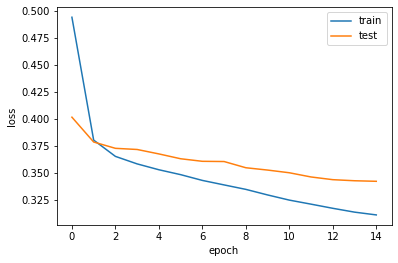

1537/1537 [==============================] - 40s 26ms/step - loss: 0.3423 - accuracy: 0.8525
loss, accuracy :  [0.3423220217227936, 0.8525133728981018]


In [9]:

# 그래프 그리기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])
plt.show() 

# 정확도
score = model.evaluate(x_test,y_test)
print("loss, accuracy : ",score)

In [ ]:
# 모델 불러오기
loaded_model = keras.models.load_model('movie-lstm.h5')

In [13]:
# 모델 불러오기
loaded_model = keras.models.load_model('/content/movie-lstm.h5')

In [17]:
# 입력받은 글자를 전처리하는 함수

def txt_predict(new_sentence):
  # 1. 한글 처리
  new_sentence = re.sub(r'[^ㄱ-하-ㅣ가-힣 ]','',new_sentence) 
  # 2. 형태소 분석
  new_sentence = okt.morphs(new_sentence,stem=True)
  # 3. 불용어 제거
  new_sentence = [word for word in new_sentence if not word in stopwords]
  # 4. 단어를 번호로 변경
  encoded = tokenizer.texts_to_sequences(new_sentence)
  # 5. 패딩
  pad_new = pad_sequences(encoded,maxlen=30)
  # 6. 예측
  score = float(loaded_model.predict(pad_new))
  if(score>0.5): #0.5이상이면 긍정 아니면 부정
    print('{:.2f}% 확률로 긍정 리뷰 입니다.'.format(score*100) )
  else:
    print('{:.2f}% 확률로 부정 리뷰 입니다.'.format((1-score)*100) )




In [23]:
# 1개의 글자를 입력받음

model.predict('뭐야')
# txt

# txt = '뭐야'
# txt_predict(txt)

IndexError: ignored

In [24]:
txt2 = '이딴게 영화야~ 감독 바꿔'
txt_predict(txt2)

ValueError: ignored